# Flower Generation

In this project, I defined and trained a DCGAN on a dataset of flowers. The original Udacity project was generating new faces, but given that GANs + generating faces = deepfakes most of the time, I decided to go another rout. My goal in this project was to design a generator network to generate *new* images of flowers that look as realistic as possible!

### Get the Data

I used the [102 Category Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.htmll) to train the adversarial network. Like the name indicates, there are 102 categories of flowers, although we won't be using the labels for this project. Instead, we can use the entire dataset of 8189 images to train on. Each of the images actually comes in different sizes, so we will need to crop the images to ensure that they are the same size. I do not believe that PyTorch currently supports training on images of different sizes. However, each of the images has three RGB color channels.

In [1]:
import os
import pickle as pkl

import numpy as np
import PIL
from PIL import Image

import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# can comment out after executing
#!unzip flowers.zip

In [2]:
data_dir = 'flowers/'
data_subdir = 'images'
images_path = os.path.join(data_dir, data_subdir)

In [3]:
print(images_path)

flowers/images


Below, we are going to read in the images with the help of the `PIL` package in Python, resize the images, crop them, and then resave the images to disk. It should be noted that I am saving the data back into its original directory, which normally you should *NOT* do if you want to experiment with different processing steps and how they affect your overall results. Howeveer, I have saved the raw data to another directory and created this zip file for the express purpose of resaving the cropped images.

**Note**: this loop only needs to be run once.

In [ ]:
#this will print the full path of indivual filenames
for filename in os.listdir(images_path):
    image_path = os.path.join(images_path, filename)

    #load in image
    pil_image = Image.open(image_path)
    
    #resize
    if pil_image.size[1] > pil_image.size[0]:
        pil_image.thumbnail((256, 9999))
    else:
        pil_image.thumbnail((9999, 256))
    
    #recalculate width and height
    width = pil_image.width
    height = pil_image.height
    
    #calculate cropping points
    to_crop = 224
    
    left = int((width - to_crop) / 2)
    bottom = int((height - to_crop) / 2)
    
    right = left + 224
    top = bottom + 224
    
    #crop the image
    pil_image = pil_image.crop((left, bottom, right, top))

    #save image
    pil_image.save(image_path)
    
print('Done processing images!')

#### ImageFolder, DataLoader
To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `flowers/` and data transformation passed in. Here, we can specify transforms that we want to apply to the data, specifically resizing each image to be a square and then making it a PyTorch Tensor. From there, we can create a `DataLoader` object for the entire training set which will allow us read in data in specified batch sizes.

In [4]:
def get_dataloader(batch_size, image_size, data_dir='flowers/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    #apply image resizing and then turn numpy arrays into torch tensors
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    #load in the data with ImageFolder
    data = datasets.ImageFolder(data_dir, transform=transform)
    
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    
    return data_loader

In [5]:
#dataloader function hyperparameters
batch_size = 32
img_size = 256

# call function and get a dataloader
flowers_train_loader = get_dataloader(batch_size, img_size)

### Visualize some example images from the data set

In [8]:
# obtain one batch of training images
dataiter = iter(flowers_train_loader)
images, _ = dataiter.next() # _ for no labels

In [8]:
np.shape(images[0])

torch.Size([3, 256, 256])

In [9]:
print(images[0][0])

tensor([[ 0.2275,  0.2196,  0.2078,  ...,  0.0431,  0.0431,  0.0431],
        [ 0.2196,  0.2157,  0.2039,  ...,  0.0431,  0.0431,  0.0431],
        [ 0.2118,  0.2078,  0.2000,  ...,  0.0431,  0.0431,  0.0431],
        ...,
        [ 0.6353,  0.6353,  0.6353,  ...,  0.0078,  0.0078,  0.0078],
        [ 0.6157,  0.6275,  0.6353,  ...,  0.0078,  0.0078,  0.0078],
        [ 0.6078,  0.6196,  0.6353,  ...,  0.0039,  0.0039,  0.0039]])


In [10]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

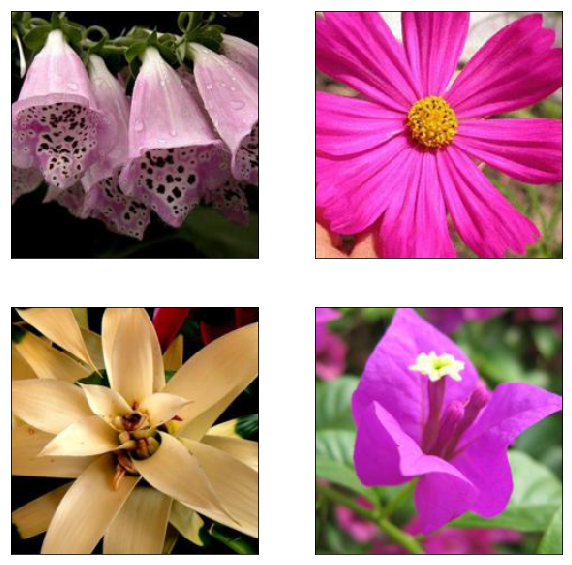

In [11]:
# obtain one batch of training images
dataiter = iter(flowers_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 10))

plot_size=4
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

### Pre-process the image data and scaling it to a pixel range of -1 to 1

GANs generally use the output of a `tanh` activated function which will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [9]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_, max_ = feature_range
    
    #example: 1 - (-1) = 2
    difference = max_ - min_
    
    #if the original range is (0, 1), then:
    #(0, 1) * 2 = (0, 2) - 1 = (-1, 1)
    x = (x * difference) - max_
    
    return x

In [10]:
# check scaled range, should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

First, we will need to define the discriminator. This is a convolutional classifier only without any maxpooling layers. To deal with this complexity of the data, we can use **batch normalization** after all of the layers except the input and output layers (first convolutional layer and linear layer). You are also allowed to create any helper functions that may be useful. The output should be a single value that will indicate whether a given image is real or fake.

In [11]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, kernel_size=4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, kernel_size=4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size=4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, kernel_size=4)
        self.conv5 = conv(conv_dim*8, conv_dim*16, kernel_size=4)    
        self.conv6 = conv(conv_dim*16, conv_dim*32, kernel_size=4)    
        self.output = nn.Linear(conv_dim*32*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        #input: (256, 256, 3)
        #output: (W − K + 2P)/S + 1 = (256 - 4 + 2)/2 + 1 = (128, 128, 16)
        x = F.leaky_relu(self.conv1(x), 0.2)
        
        #output: (W − K + 2P)/S + 1 = (128 - 4 + 2)/2 + 1 = (64, 64, 32)
        x = F.leaky_relu(self.conv2(x), 0.2)
        
        #output: (W − K + 2P)/S + 1 = (64 - 4 + 2)/2 + 1 = (32, 32, 64)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        #output: (W − K + 2P)/S + 1 = 32 - 4 + 2)/2 + 1 = (16, 16, 128)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        #output: (W − K + 2P)/S + 1 = (16 - 4 + 2)/2 + 1 = (8, 8, 256)
        x = F.leaky_relu(self.conv5(x), 0.2)
        
        #output: (W − K + 2P)/S + 1 = (8 - 4 + 2)/2 + 1 = (4, 4, 512)
        x = F.leaky_relu(self.conv6(x), 0.2)
        
        #flatten before fully connected layer
        #shape is flattened to (x_dim, y_dim, conv_dim*8)
        x = x.view(-1, self.conv_dim*32*4*4)
        x = self.output(x)
        
        return x

## Generator

The generator will upsample an input and generate a *new* image of the same size as our training data `256x256x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

In [13]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(deconv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.z_size = z_size
        self.conv_dim = conv_dim
        
        #same dimension as our linear layer in discriminator
        self.latentz = nn.Linear(z_size, 4*4*conv_dim*32)
        
        self.deconv1 = deconv(conv_dim*32, conv_dim*16, kernel_size=4)
        self.deconv2 = deconv(conv_dim*16, conv_dim*8, kernel_size=4)
        self.deconv3 = deconv(conv_dim*8, conv_dim*4, kernel_size=4)
        self.deconv4 = deconv(conv_dim*4, conv_dim*2, kernel_size=4)
        self.deconv5 = deconv(conv_dim*2, conv_dim, kernel_size=4)
        self.deconv6 = deconv(conv_dim, 3, kernel_size=4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 256x256x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.latentz(x)
        x = x.view(-1, self.conv_dim*32, 4, 4)
        
        #input: (4, 4, 512)
        #output: = S*(W-1) + K - 2*P = 2*(4-1) + 4 - 2 = (8, 8, 256)
        x = F.relu(self.deconv1(x), 0.2)
        
        #output: = S*(W-1) + K - 2*P = 2*(8-1) + 4 - 2 = (16, 16, 128)
        x = F.relu(self.deconv2(x), 0.2)
        
        #output: = S*(W-1) + K - 2*P = 2*(16-1) + 4 - 2 = (32, 32, 64)
        x = F.relu(self.deconv3(x), 0.2)
        
        #output: = S*(W-1) + K - 2*P = 2*(32-1) + 4 - 2 = (64, 64, 32)
        x = F.relu(self.deconv4(x), 0.2)
        
        #output: = S*(W-1) + K - 2*P = 2*(64-1) + 4 - 2 = (128, 128, 16)
        x = F.relu(self.deconv5(x), 0.2)
        
        #output: = S*(W-1) + K - 2*P = 2*(128-1) + 4 - 2 = (256, 256, 3)
        x = F.tanh(self.deconv6(x))
        
        return x

## Initialize the weights of the networks

From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, we can define a weight initialization function that does just this! This should initialize only **convolutional** and **linear** layers with a normal distribution around 0, a standard deviation of 0.002, and bias terms (if they  exist) are set to 0.

In [15]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    init_gain=0.02
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, init_gain)

        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
   
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, init_gain)
        nn.init.constant_(m.bias.data, 0.0)

## Build complete network

Here I'll define my models' hyperparameters and instantiate the discriminator and generator from the classes defined above.

In [16]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [17]:
#define model hyperparams
d_conv_dim = 16
g_conv_dim = 16
z_size = 100

#create models
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv6): Sequential(
    (0): Conv2d(256, 512, kernel

### Training on GPU

Check if we can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, we can be make sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
#check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* We want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*. Often, GANs use the cross entropy loss function, but the LSGAN [paper](https://arxiv.org/abs/1611.04076) showed that often GANs have more stability while training with the least squares error loss. This is what I will use.

In [19]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out-1)**2)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss =  torch.mean(D_out**2)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for the models with appropriate hyperparameters.

In [20]:
lr = 0.001
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use the functions `real_loss` and `fake_loss` to help calculate the discriminator losses. We should also save some generated "fake" samples after each epoch so that we can inspect them later and see how the generator is improving.

In [21]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
   
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(flowers_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ========================
            #         TRAINING        
            # ========================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            #get discriminator output for real images
            D_real = D(real_images)
            
            #calculate discriminator loss based on real images
            d_real_loss = real_loss(D_real)
            
            #generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            
            #compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            #generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            
            #compute the discriminator losses on fake images 
            D_fake = D(fake_images)
            
            #use real loss to flip labels
            g_loss = real_loss(D_fake)
        
            #perform backprop
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))

  
        #generate and save sample, fake images
        #switch to evaluation mode for generating samples
        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        
        #back to training mode
        G.train()
        
    print('\nFinished training! \n')
    
    #return losses
    return losses, samples

Set the number of training epochs and train the GAN!

In [22]:
# set number of epochs 
n_epochs = 50

# call training function
from workspace_utils import active_session

with active_session():
    losses, samples = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 2.5945 | g_loss: 9.1213
Epoch [    1/   50] | d_loss: 0.3619 | g_loss: 1.9106
Epoch [    1/   50] | d_loss: 0.6595 | g_loss: 1.5881
Epoch [    1/   50] | d_loss: 0.2876 | g_loss: 1.4867
Epoch [    1/   50] | d_loss: 0.1415 | g_loss: 1.4360
Epoch [    1/   50] | d_loss: 0.1199 | g_loss: 1.7405
Epoch [    2/   50] | d_loss: 0.1211 | g_loss: 1.0564
Epoch [    2/   50] | d_loss: 0.6884 | g_loss: 1.1876
Epoch [    2/   50] | d_loss: 1.5885 | g_loss: 1.2816
Epoch [    2/   50] | d_loss: 1.4518 | g_loss: 3.1559
Epoch [    2/   50] | d_loss: 0.1667 | g_loss: 0.8487
Epoch [    2/   50] | d_loss: 0.1804 | g_loss: 0.9941
Epoch [    3/   50] | d_loss: 0.0983 | g_loss: 0.7231
Epoch [    3/   50] | d_loss: 0.1447 | g_loss: 1.3023
Epoch [    3/   50] | d_loss: 0.2884 | g_loss: 1.3916
Epoch [    3/   50] | d_loss: 0.2522 | g_loss: 1.1004
Epoch [    3/   50] | d_loss: 0.3439 | g_loss: 0.7531
Epoch [    3/   50] | d_loss: 0.0232 | g_loss: 1.1692
Epoch [    4/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

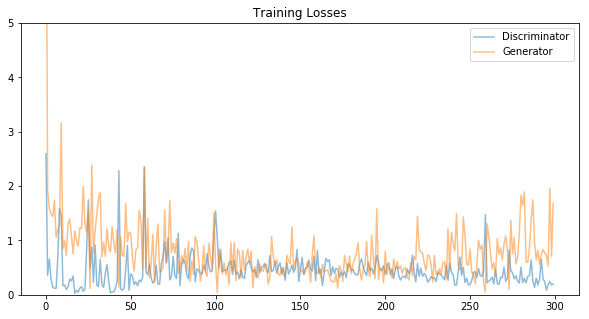

In [25]:
#convert losses to array so we can transpose them for plotting
losses = np.array(losses)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.ylim([0, 5])
plt.title("Training Losses")
plt.legend()
plt.show()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(20, 5), nrows=2, ncols=8, sharey=True, sharex=True)
    
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        im = ax.imshow(img.reshape((256, 256, 3)))
        
    plt.show()

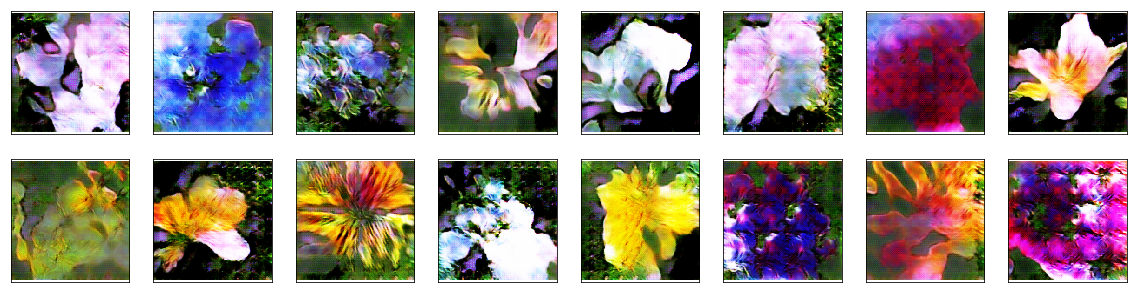

In [27]:
#view samples from last epoch
_ = view_samples(-1, samples)

Neat! The generated images are pretty wild looking, but are starting to resemble real flowers. If we trained longer, we might be able to get more realistic output samples.

I feel good about the optimizer and hyperparameter choices in general. However, the model size is pretty deep and after only 30 epochs the generator and discriminator loss functions meet (the discriminator's ability to recognize generated images matches the generator's ability to trick the Discriminator with "fake" images.

I also initially tried 100 epochs, but the losses seemed to meet after only 50 epochs. The discriminator loss trends downward and the generator loss trends upward after decreasing sharply (the discriminator quickly learns what is a generated image), both of which are what we expect to see when training a GAN.